# ***IMPORTING REQUIRED LIBRARIES***

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#Set style for cleaner visuals
sns.set(style="darkgrid")

# ***STEP 1: DATA CLEANING***

In [139]:
#LOAD THE DATASET
df = pd.read_excel('online_retail.xlsx')
print("Original dataset shape:", df.shape)

# 1. Handle missing values (CustomerID and Description)
df = df.dropna(subset=['Customer ID', 'Description'])
print("After dropping missing CustomerID & Description:", df.shape)

# 2. Remove duplicate rows
df = df.drop_duplicates()
print("After dropping duplicates:", df.shape)

# 3. Drop canceled orders (InvoiceNo starting with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]
print("After removing canceled orders:", df.shape)

# 4. Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 5. Handle outliers in Quantity and UnitPrice
# Remove rows with negative or zero quantity or unit price
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]
print("After removing negative/zero Quantity and UnitPrice:", df.shape)

# Optionally, cap extreme outliers using IQR method
Q1_quantity = df['Quantity'].quantile(0.25)
Q3_quantity = df['Quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity

Q1_price = df['Price'].quantile(0.25)
Q3_price = df['Price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

# Cap the outliers to 1.5*IQR
quantity_upper_limit = Q3_quantity + 1.5 * IQR_quantity
price_upper_limit = Q3_price + 1.5 * IQR_price

df = df[(df['Quantity'] <= quantity_upper_limit) & (df['Price'] <= price_upper_limit)]
print("After capping Quantity and UnitPrice outliers:", df.shape)

# Final check
print("\nCleaned dataset preview:")
print(df.head())


Original dataset shape: (525461, 8)
After dropping missing CustomerID & Description: (417534, 8)
After dropping duplicates: (410763, 8)
After removing canceled orders: (400947, 8)
After removing negative/zero Quantity and UnitPrice: (400916, 8)
After capping Quantity and UnitPrice outliers: (342273, 8)

Cleaned dataset preview:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
5  489434     22064           PINK DOUGHNUT TRINKET POT         24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
4 2009-12

# ***Step 2: Exploratory Data Analysis***

**1. GENERAL OVERVIEW**

In [140]:
# 1. Number of unique products
unique_products = df['StockCode'].nunique()
print("✅ Unique Products:", unique_products)

# 2. Number of transactions (unique InvoiceNo)
unique_transactions = df['Invoice'].nunique()
print("✅ Number of Transactions:", unique_transactions)

# 3. Number of unique customers
unique_customers = df['Customer ID'].nunique()
print("✅ Unique Customers:", unique_customers)

# 4. List of countries involved
countries = df['Country'].nunique()
country_list = df['Country'].unique()
print("✅ Number of Countries:", countries)
print("🌍 Countries Involved:", country_list)


Dataset shape: (342273, 8)
✅ Unique Products: 3644
✅ Number of Transactions: 17216
✅ Unique Customers: 4140
✅ Number of Countries: 37
🌍 Countries Involved: ['United Kingdom' 'France' 'Australia' 'EIRE' 'Germany' 'Portugal'
 'Poland' 'Channel Islands' 'Netherlands' 'Spain' 'Cyprus' 'Belgium'
 'Greece' 'Norway' 'Austria' 'United Arab Emirates' 'Finland' 'Denmark'
 'Italy' 'Switzerland' 'Sweden' 'USA' 'Japan' 'Unspecified' 'Malta' 'RSA'
 'Singapore' 'Bahrain' 'Israel' 'Thailand' 'Lithuania' 'Nigeria'
 'West Indies' 'Korea' 'Brazil' 'Canada' 'Iceland']


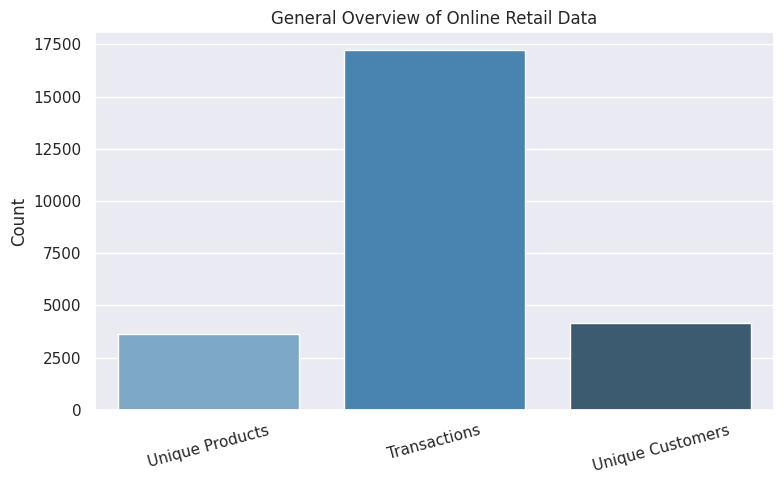

In [141]:
# Prepare the data
labels = ['Unique Products', 'Transactions', 'Unique Customers']
values = [
    df['StockCode'].nunique(),
    df['Invoice'].nunique(),
    df['Customer ID'].nunique(),
]

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=values, hue= labels, palette="Blues_d", legend= False)
plt.title("General Overview of Online Retail Data")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


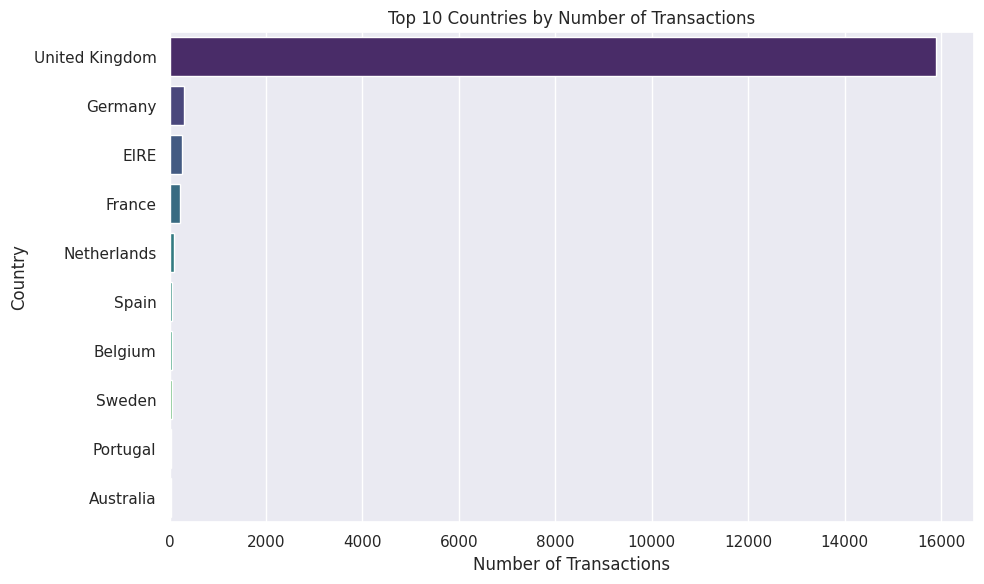

In [142]:
# Top 10 countries by transaction count
top_countries = df.groupby('Country')['Invoice'].nunique().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.values, y=top_countries.index,hue=top_countries.index, palette="viridis")
plt.title("Top 10 Countries by Number of Transactions")
plt.xlabel("Number of Transactions")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


**2. PRODUCT ANALYSIS**

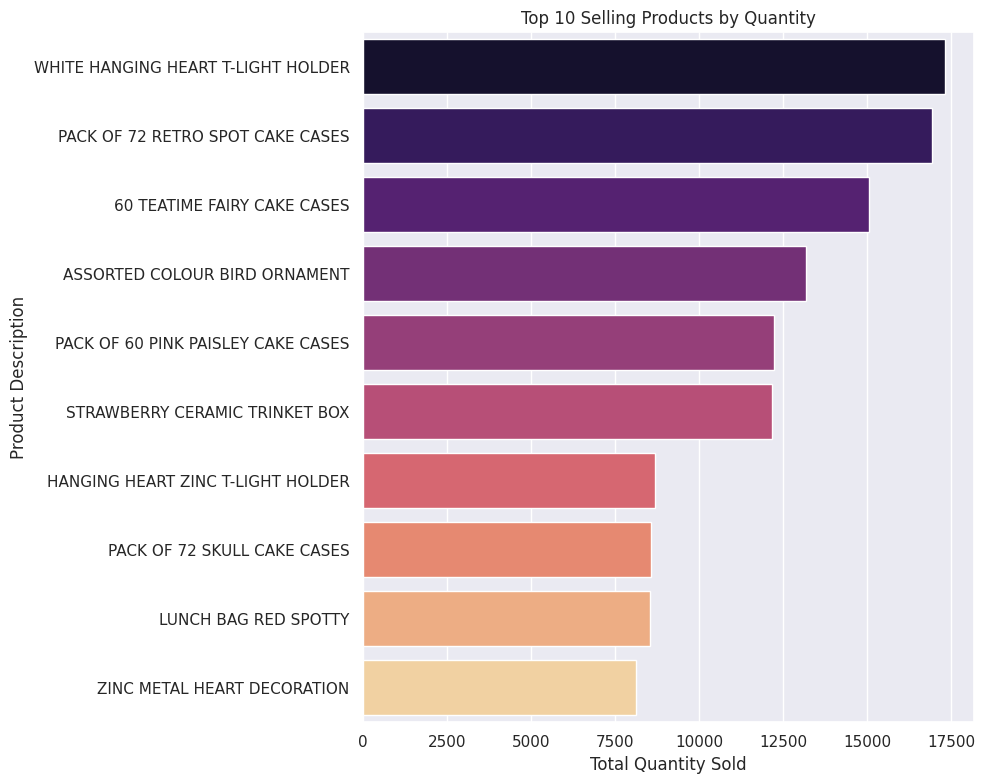

In [143]:
# TOP 10 SELLING PRODUCTS BY QUANTITY
top_selling = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_selling.values, y=top_selling.index, hue=top_selling.index, palette='magma', orient="h")
plt.title("Top 10 Selling Products by Quantity")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Description")
plt.tight_layout()
plt.show()


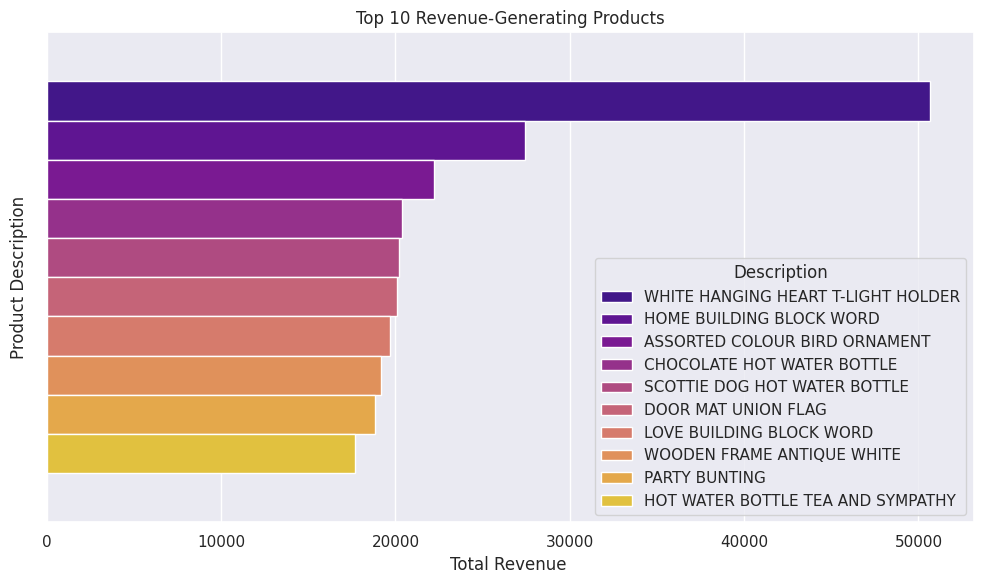

In [144]:
# Add a new column for total revenue per row
df['TotalPrice'] = df['Quantity'] * df['Price']

top_revenue = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_revenue.values, hue=top_revenue.index, palette='plasma')
plt.title("Top 10 Revenue-Generating Products")
plt.xlabel("Total Revenue ")
plt.ylabel("Product Description")
plt.tight_layout()
plt.show()


In [145]:
#Products with zero or negative prices (to check for anomalies)
anomalies = df[df['Price'] <= 0]
print("Number of products with zero or negative price:", anomalies.shape[0])
print("Sample anomalies:\n", anomalies[['StockCode', 'Description', 'Price']].drop_duplicates().head())


Number of products with zero or negative price: 0
Sample anomalies:
 Empty DataFrame
Columns: [StockCode, Description, Price]
Index: []


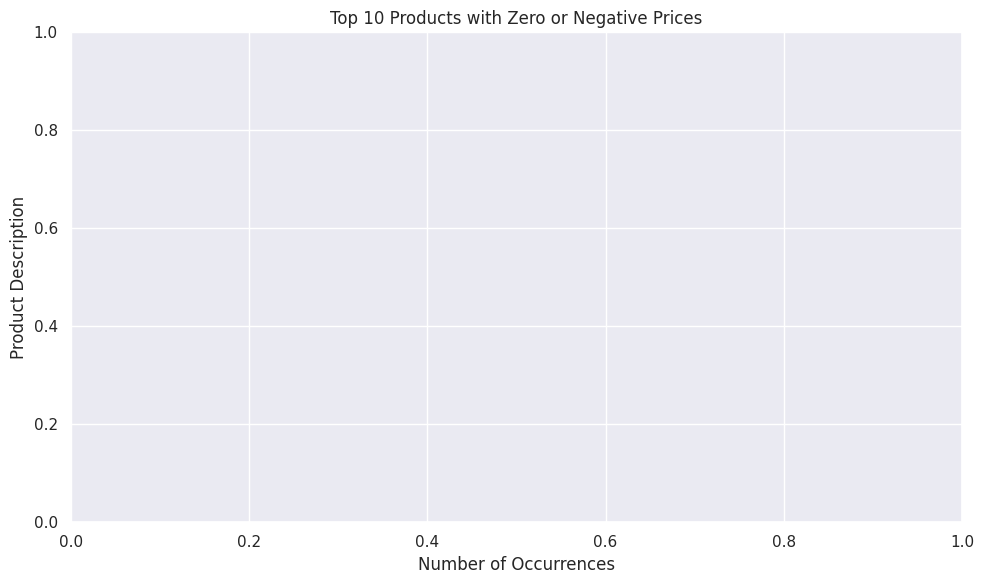

In [146]:
# Filter rows with zero or negative price
anomalies = df[df['Price'] <= 0]

# Group and count by product description
anomaly_counts = anomalies['Description'].value_counts().head(10)

# Plot (The Graph will be empty as we have already cleaned missing or negative values in preprocessing step)
plt.figure(figsize=(10, 6))
sns.barplot(x=anomaly_counts.values, y=anomaly_counts.index, palette='Reds_r')
plt.title("Top 10 Products with Zero or Negative Prices")
plt.xlabel("Number of Occurrences")
plt.ylabel("Product Description")
plt.tight_layout()
plt.show()


**3. Customer Analysis**

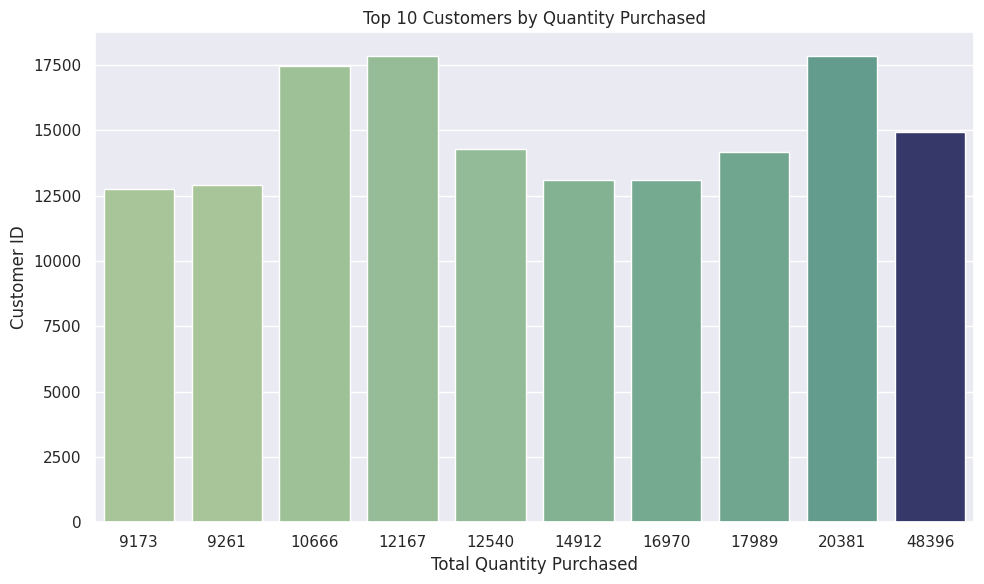

In [147]:
#Top customers by quantity of items purchased
top_customers_qty = df.groupby('Customer ID')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_customers_qty.values, y=top_customers_qty.index.astype(int),hue=top_customers_qty.values, palette='crest', legend= False)
plt.title("Top 10 Customers by Quantity Purchased")
plt.xlabel("Total Quantity Purchased")
plt.ylabel("Customer ID")
plt.tight_layout()
plt.show()


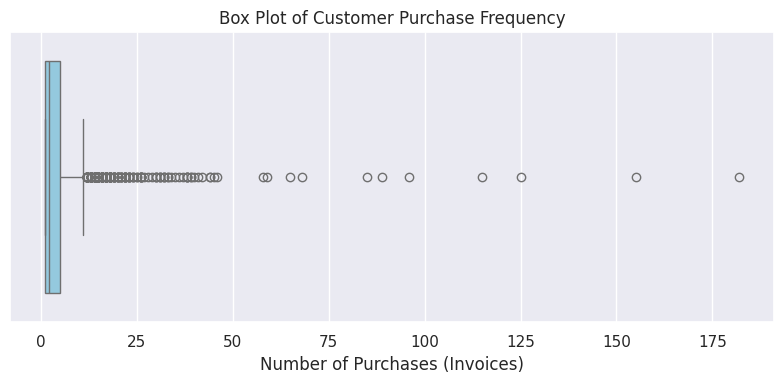

In [165]:
# Number of invoices per customer
invoices_per_customer = df.groupby('Customer ID')['Invoice'].nunique()

plt.figure(figsize=(8, 4))
sns.boxplot(x=invoices_per_customer, color='skyblue', legend=True)
plt.title("Box Plot of Customer Purchase Frequency")
plt.xlabel("Number of Purchases (Invoices)")
plt.tight_layout()
plt.show()

🟢 Number of loyal customers (more than 30 invoices): 36
Sample Loyal Customers:
 Customer ID
14911.0    182
17850.0    155
12748.0    125
15311.0    115
14606.0     96
Name: Invoice, dtype: int64


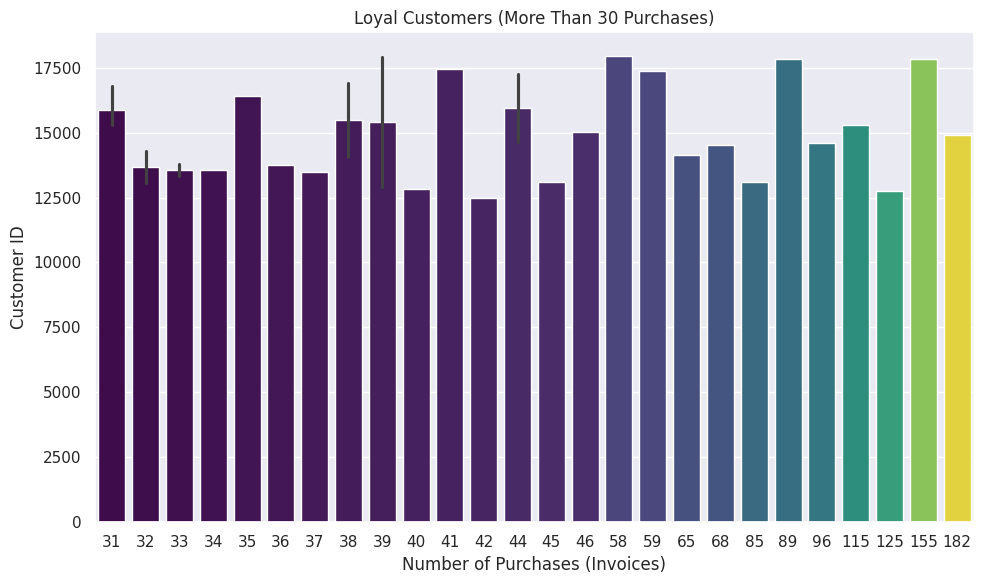

In [149]:
#Detect loyal customers (those with frequent or high purchases)
loyal_customers = invoices_per_customer[invoices_per_customer > 30]
print("🟢 Number of loyal customers (more than 30 invoices):", loyal_customers.shape[0])
print("Sample Loyal Customers:\n", loyal_customers.sort_values(ascending=False).head())
# Filter loyal customers
loyal_customers = invoices_per_customer[invoices_per_customer > 30].sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=loyal_customers.values, y=loyal_customers.index.astype(int),hue=loyal_customers.values, palette='viridis', legend= False)
plt.title("Loyal Customers (More Than 30 Purchases)")
plt.xlabel("Number of Purchases (Invoices)")
plt.ylabel("Customer ID")
plt.tight_layout()
plt.show()


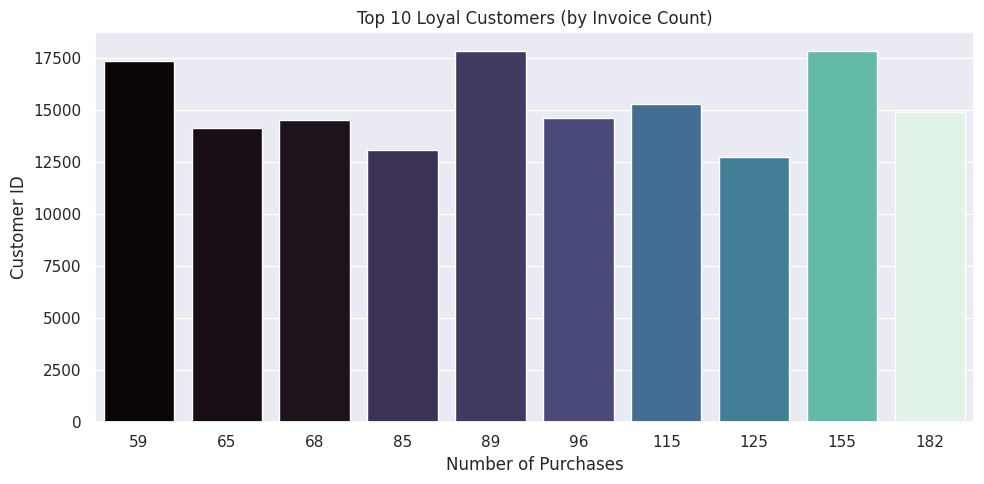

In [166]:
#Visualizing Top 10 Loyal Customers
top_loyal_customers = loyal_customers.head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_loyal_customers.values, y=top_loyal_customers.index.astype(int),hue=top_loyal_customers.values, palette='mako', legend= False)
plt.title("Top 10 Loyal Customers (by Invoice Count)")
plt.xlabel("Number of Purchases")
plt.ylabel("Customer ID")
plt.tight_layout()
plt.show()


**4. Time Series Analysis**

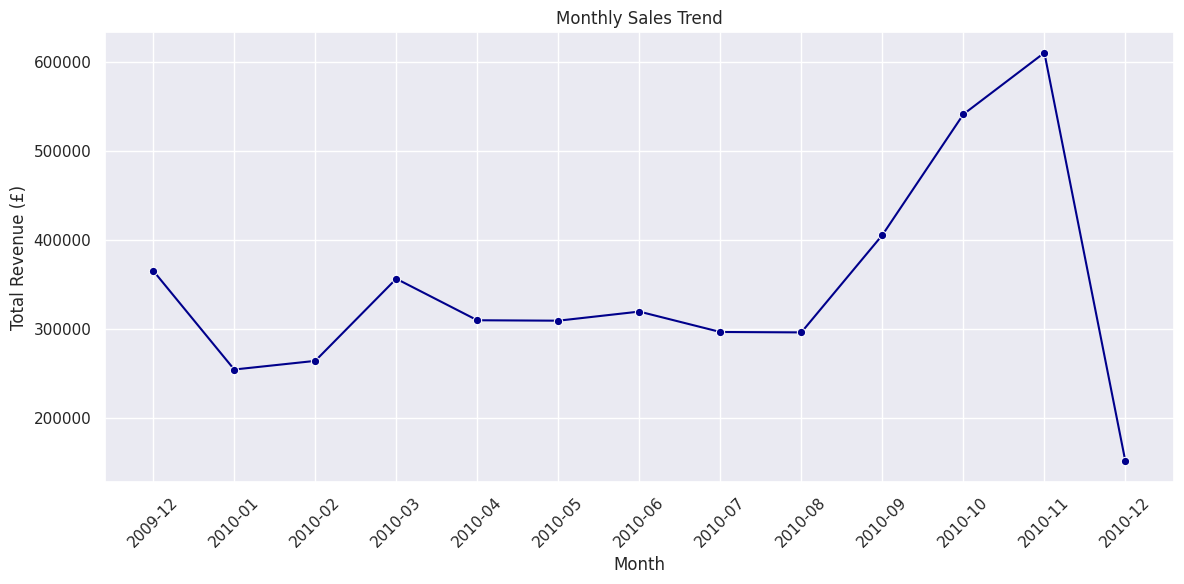

In [151]:
# Monthly Sales Trend
# Extract month and year
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

# Group by month
monthly_sales = df.groupby('InvoiceMonth')['TotalPrice'].sum().reset_index()
monthly_sales['InvoiceMonth'] = monthly_sales['InvoiceMonth'].astype(str)  # Convert Period to string for plotting

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='InvoiceMonth', y='TotalPrice', marker='o', color='darkblue')
plt.xticks(rotation=45)
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()


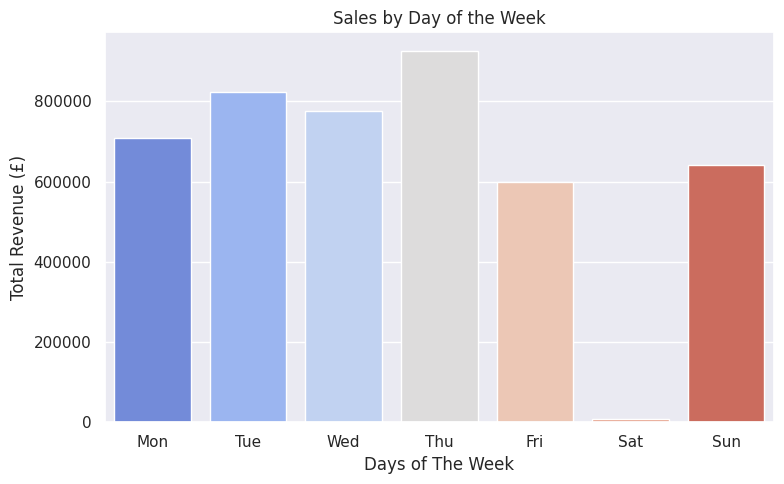

In [152]:
# Weekly Sales Trend
# Extract day of week (0=Monday, 6=Sunday)
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
dow_sales = df.groupby('DayOfWeek')['TotalPrice'].sum()

# Day labels
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=day_labels, y=dow_sales.values, palette='coolwarm')
plt.title("Sales by Day of the Week")
plt.xlabel("Days of The Week")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()


In [153]:
#Identifying Peak & Slow Months
peak_month = monthly_sales.loc[monthly_sales['TotalPrice'].idxmax()]
low_month = monthly_sales.loc[monthly_sales['TotalPrice'].idxmin()]

print("📈 Peak Sales Month:", peak_month['InvoiceMonth'], "with £", round(peak_month['TotalPrice'], 2))
print("📉 Lowest Sales Month:", low_month['InvoiceMonth'], "with £", round(low_month['TotalPrice'], 2))


📈 Peak Sales Month: 2010-11 with £ 610665.45
📉 Lowest Sales Month: 2010-12 with £ 150954.27


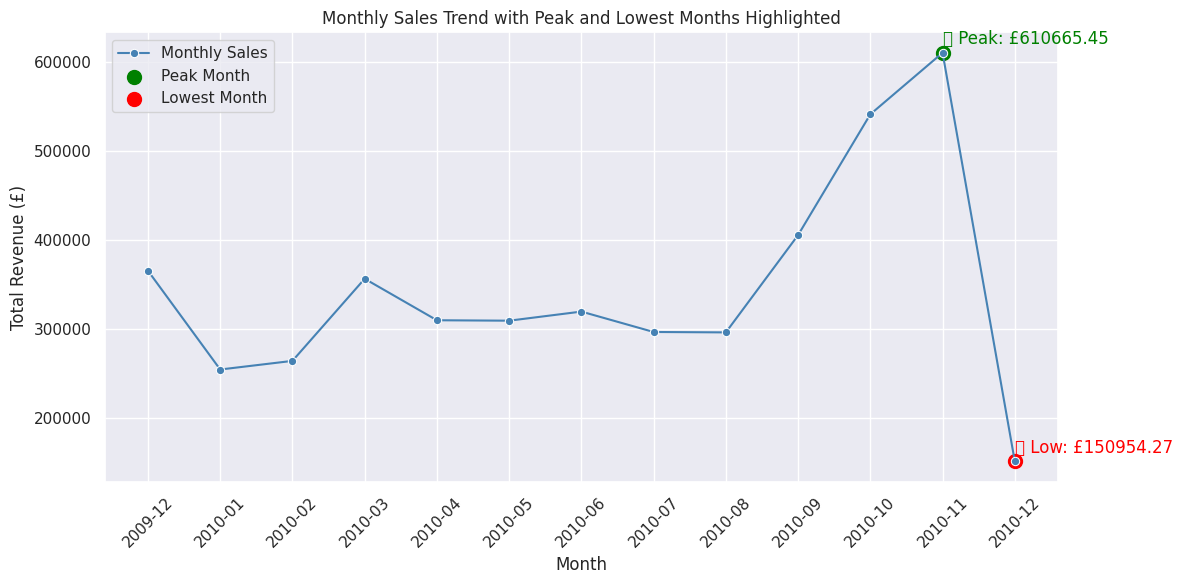

In [154]:
#Visualization for Peak & Lowest Sales Months
# Find peak and lowest month
peak_month = monthly_sales.loc[monthly_sales['TotalPrice'].idxmax()]
low_month = monthly_sales.loc[monthly_sales['TotalPrice'].idxmin()]

# Plot the monthly sales line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='InvoiceMonth', y='TotalPrice', marker='o', color='steelblue', label='Monthly Sales')

# Highlight peak month
plt.scatter(peak_month['InvoiceMonth'], peak_month['TotalPrice'], color='green', s=100, label='Peak Month')
plt.text(peak_month['InvoiceMonth'], peak_month['TotalPrice'] + 10000,
         f"📈 Peak: £{round(peak_month['TotalPrice'], 2)}", color='green')

# Highlight lowest month
plt.scatter(low_month['InvoiceMonth'], low_month['TotalPrice'], color='red', s=100, label='Lowest Month')
plt.text(low_month['InvoiceMonth'], low_month['TotalPrice'] + 10000,
         f"📉 Low: £{round(low_month['TotalPrice'], 2)}", color='red')

# Formatting
plt.xticks(rotation=45)
plt.title("Monthly Sales Trend with Peak and Lowest Months Highlighted")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.legend()
plt.tight_layout()
plt.show()


**5. Country-Wise Analysis**

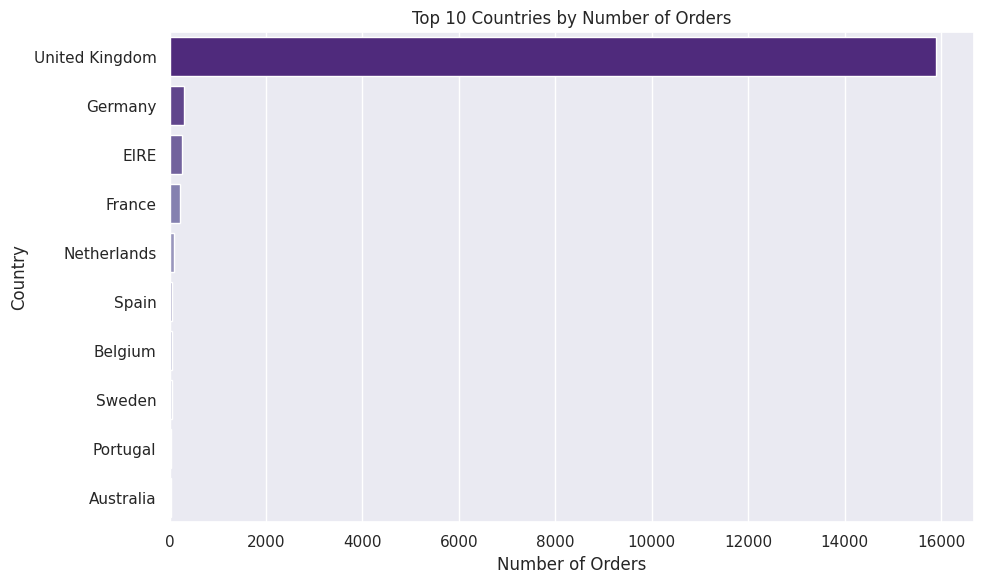

In [155]:
# Countries with the Highest Number of Orders
# Count unique invoices (orders) per country
country_orders = df.groupby('Country')['Invoice'].nunique().sort_values(ascending=False)

# Plot Top 10
top10_orders = country_orders.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top10_orders.values, y=top10_orders.index, palette='Purples_r')
plt.title("Top 10 Countries by Number of Orders")
plt.xlabel("Number of Orders")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


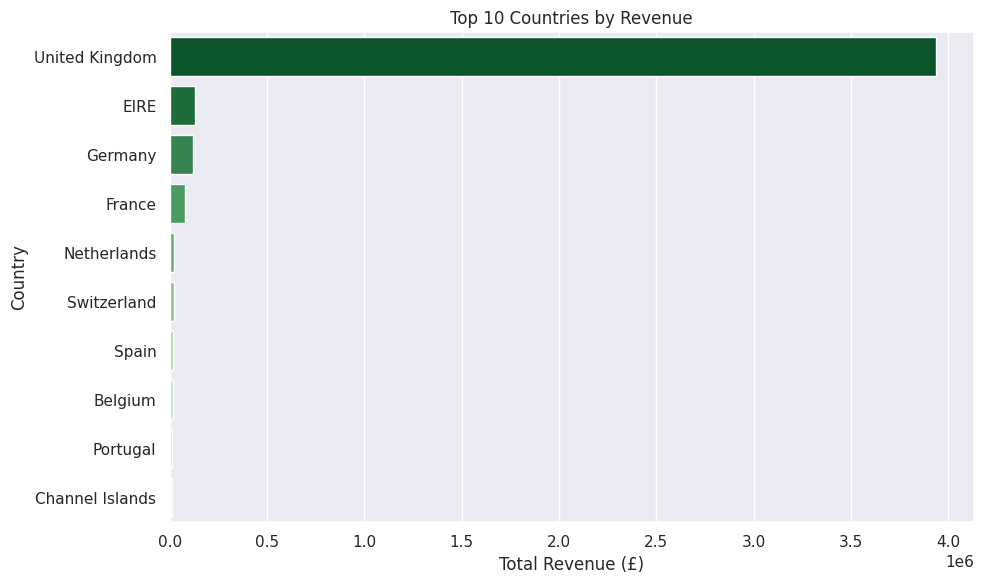

In [156]:
# Total Revenue by Country
# Sum of TotalPrice per country
country_revenue = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

# Plot Top 10 Revenue Countries
top10_revenue = country_revenue.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top10_revenue.values, y=top10_revenue.index, palette='Greens_r')
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Total Revenue (£)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


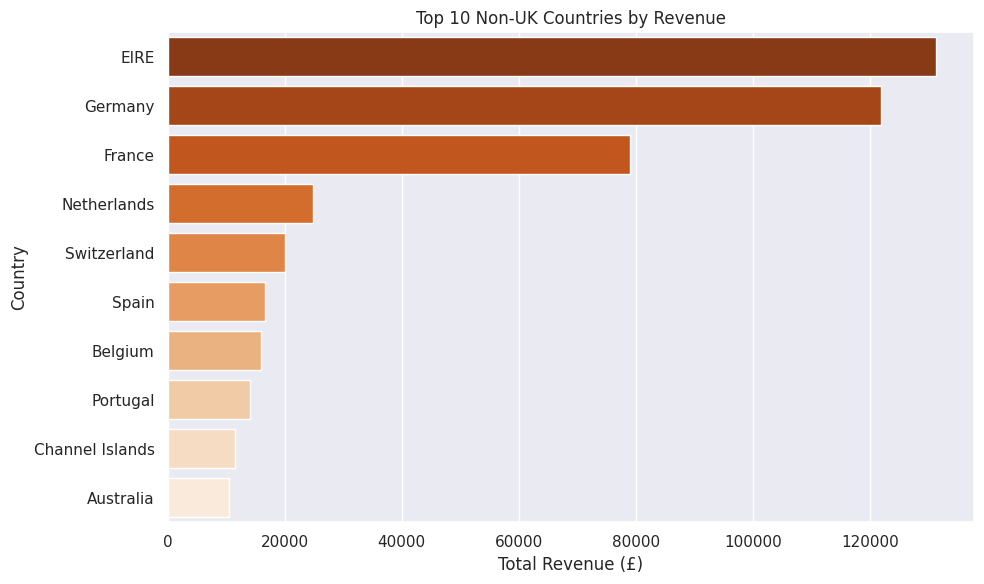

In [157]:
# Exclude UK for a Clearer View As UK is Dominating Others
# Revenue without UK
non_uk_revenue = country_revenue.drop('United Kingdom').head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=non_uk_revenue.values, y=non_uk_revenue.index, palette='Oranges_r')
plt.title("Top 10 Non-UK Countries by Revenue")
plt.xlabel("Total Revenue (£)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


**6. RFM Segmentation — Recency, Frequency, and Monetary Analysis**

In [158]:
# 1. Set a Reference Date for Recency
# Reference date: day after last invoice
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Reference date for recency calculation:", reference_date)


Reference date for recency calculation: 2010-12-10 20:01:00


In [159]:
# 2. Calculate RFM Values
# Group by CustomerID
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm.reset_index()


In [160]:
# 3. RFM Scoring (Using Quartiles)
# Score using quantiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Create RFM segment
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Add RFM Score (sum of all three)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int).sum(axis=1)

print(rfm.head())


   Customer ID  Recency  Frequency  Monetary R_Score F_Score M_Score  \
0      12346.0      165         11    372.86       1       4       2   
1      12347.0        3          2   1224.17       4       2       4   
2      12348.0       74          1    222.16       2       1       2   
3      12349.0       43          2   1635.89       3       2       4   
4      12351.0       11          1    288.18       4       1       2   

  RFM_Segment  RFM_Score  
0         142          7  
1         424         10  
2         212          5  
3         324          9  
4         412          7  


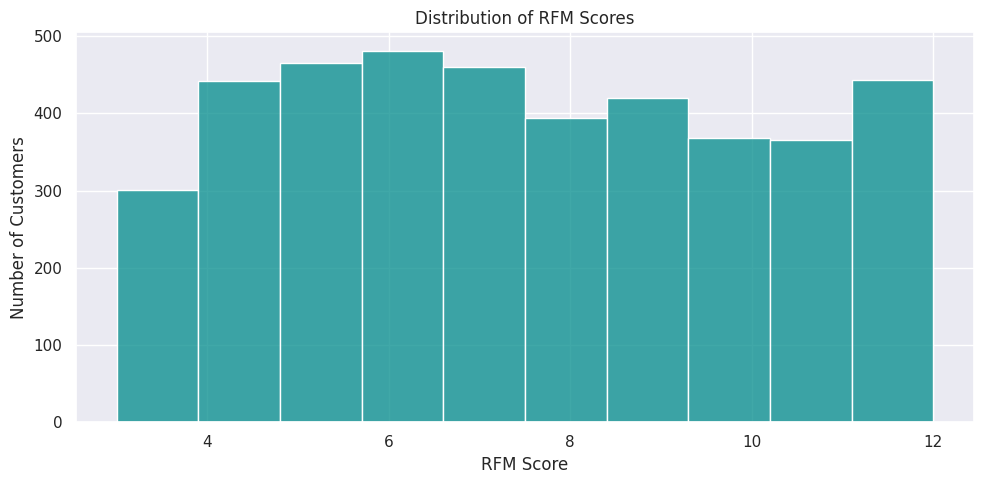

In [161]:
# 4. Visualize RFM Segments
# Histogram of RFM Scores

plt.figure(figsize=(10, 5))
sns.histplot(rfm['RFM_Score'], bins=10, kde=False, color='darkcyan')
plt.title("Distribution of RFM Scores")
plt.xlabel("RFM Score")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()


Top VIP Customers:
       Customer ID  Recency  Frequency  Monetary R_Score F_Score M_Score  \
4003      18087.0       15         12   1675.26       4       4       4   
3997      18077.0        2          8   1685.81       4       4       4   
3995      18075.0       10         10   2707.20       4       4       4   
4056      18168.0        8         11   1898.82       4       4       4   
4042      18145.0       18          7   2143.42       4       4       4   

     RFM_Segment  RFM_Score  
4003         444         12  
3997         444         12  
3995         444         12  
4056         444         12  
4042         444         12  


<Axes: xlabel='RFM_Score', ylabel='Customer ID'>

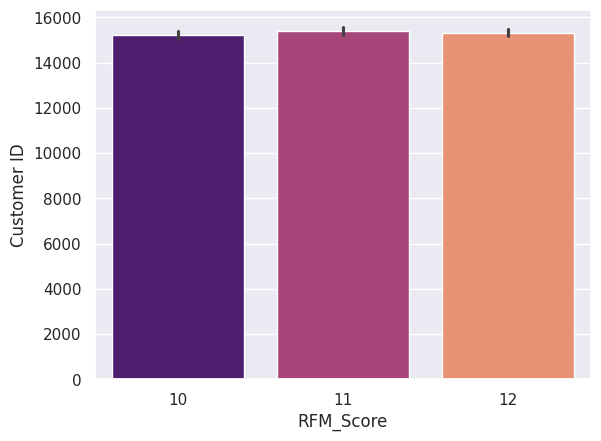

In [162]:
# Identifying VIP Customers
vip_customers = rfm[rfm['RFM_Score'] >= 10].sort_values(by='RFM_Score', ascending=False)
print("Top VIP Customers:\n", vip_customers.head())
sns.barplot(x=vip_customers['RFM_Score'], y=vip_customers['Customer ID'], palette='magma')


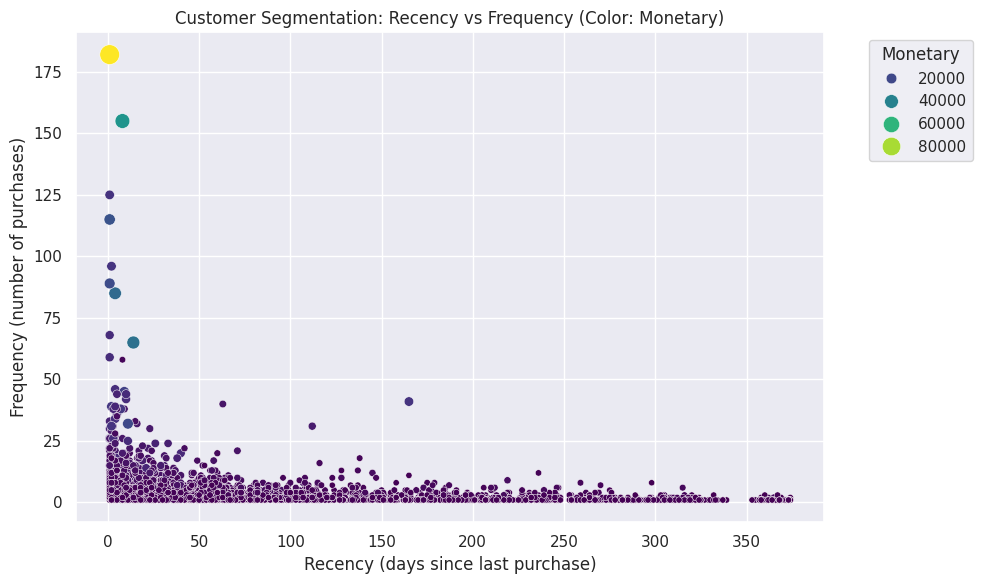

In [163]:
# Recency vs Frequency Scatter Plot (colored by Monetary)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Monetary', palette='viridis', size='Monetary', sizes=(20, 200))
plt.title("Customer Segmentation: Recency vs Frequency (Color: Monetary)")
plt.xlabel("Recency (days since last purchase)")
plt.ylabel("Frequency (number of purchases)")
plt.legend(title='Monetary', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


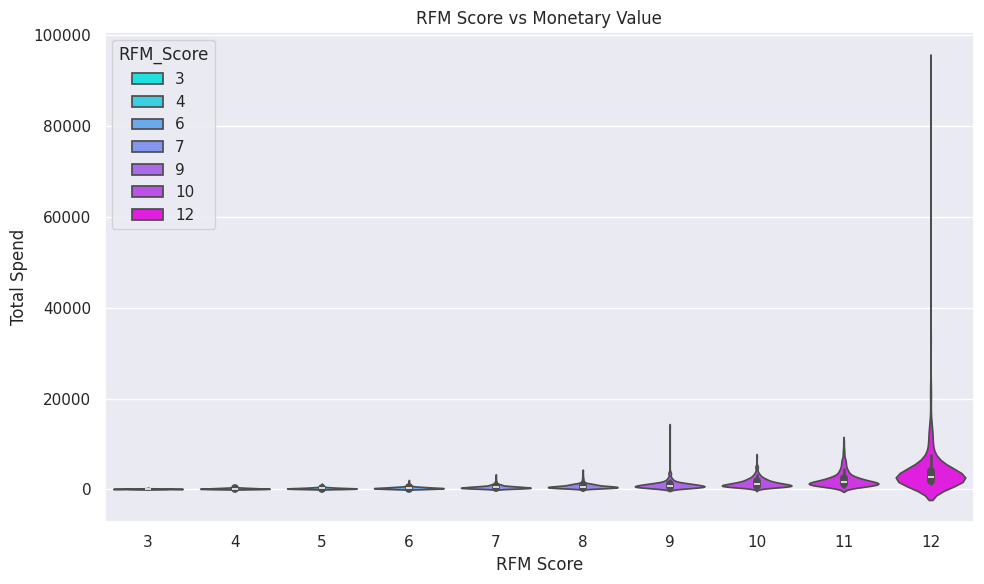

In [164]:
# RFM SCORE VS MONETORY VALUE
plt.figure(figsize=(10, 6))
sns.violinplot(data=rfm, x='RFM_Score', y='Monetary', hue='RFM_Score', palette='cool', legend=True)
plt.title("RFM Score vs Monetary Value")
plt.xlabel("RFM Score")
plt.ylabel("Total Spend")
plt.tight_layout()
plt.show()


# ***SUMMARIZING ALL THE FINDINGS***

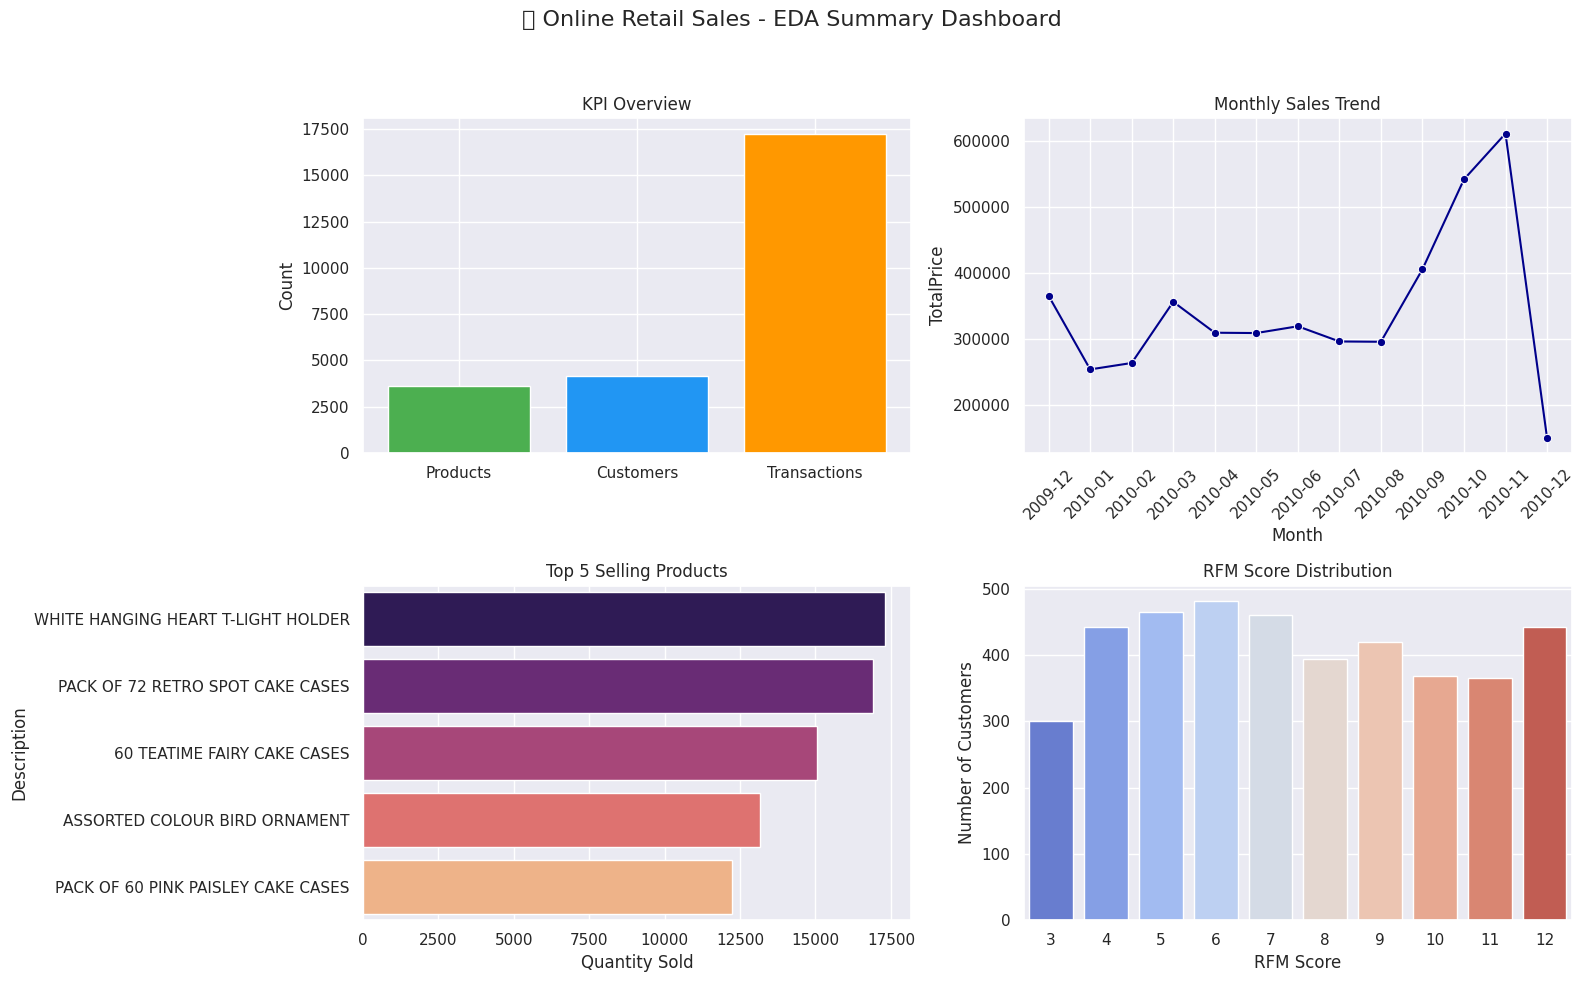

In [168]:
# Prepare small summary values
unique_products = df['StockCode'].nunique()
unique_customers = df['Customer ID'].nunique()
unique_transactions = df['Invoice'].nunique()
monthly_sales = df.groupby(df['InvoiceDate'].dt.to_period('M'))['TotalPrice'].sum().reset_index()
monthly_sales['InvoiceDate'] = monthly_sales['InvoiceDate'].astype(str)

top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(5)
rfm_score_counts = rfm['RFM_Score'].value_counts().sort_index()

# Create dashboard figure
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("🛍️ Online Retail Sales - EDA Summary Dashboard", fontsize=16)

# Subplot 1: KPI Counts
axs[0, 0].bar(['Products', 'Customers', 'Transactions'],
              [unique_products, unique_customers, unique_transactions],
              color=['#4CAF50', '#2196F3', '#FF9800'])
axs[0, 0].set_title("KPI Overview")
axs[0, 0].set_ylabel("Count")

# Subplot 2: Monthly Sales Trend
sns.lineplot(ax=axs[0, 1], data=monthly_sales, x='InvoiceDate', y='TotalPrice', marker='o', color='darkblue')
axs[0, 1].set_title("Monthly Sales Trend")
axs[0, 1].set_xlabel("Month")
axs[0, 1].tick_params(axis='x', rotation=45)

# Subplot 3: Top Selling Products
sns.barplot(ax=axs[1, 0], x=top_products.values, y=top_products.index, palette='magma')
axs[1, 0].set_title("Top 5 Selling Products")
axs[1, 0].set_xlabel("Quantity Sold")

# Subplot 4: RFM Score Distribution
sns.barplot(ax=axs[1, 1], x=rfm_score_counts.index, y=rfm_score_counts.values, palette='coolwarm')
axs[1, 1].set_title("RFM Score Distribution")
axs[1, 1].set_xlabel("RFM Score")
axs[1, 1].set_ylabel("Number of Customers")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
